# Chap 03.03. VAE with Fashion


----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----


- Ref : https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main/notebooks/03_vae/02_vae_fashion

## 0. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

## 1. Parameters

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 2. Prepare Data

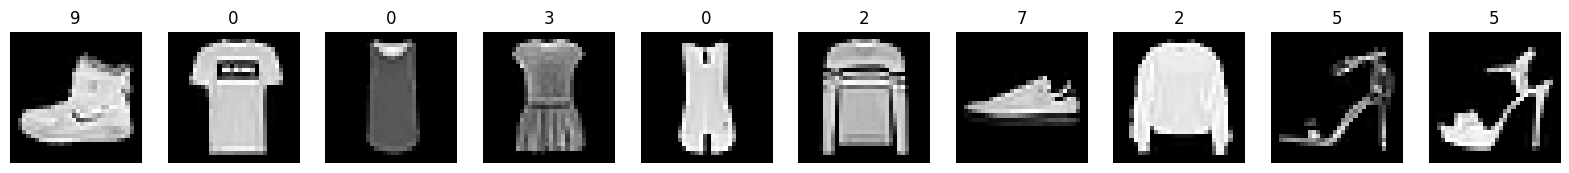

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Show some items of clothing from the training set
plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
    plt.title(y_train[i])
plt.show()

## 3. Build Autoencoder Netwrok

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# print(shape_before_flattening)
# print(np.prod(shape_before_flattening))

2025-05-06 12:57:31.563173: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-06 12:57:31.563201: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-06 12:57:31.563209: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-06 12:57:31.563246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-06 12:57:31.563260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [6]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [7]:
# VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 4.Train the AutoEncoder Model

In [9]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./temp/checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

# Save the final models
vae.save("./temp/models/vae")
encoder.save("./temp/models/encoder")
decoder.save("./temp/models/decoder")

Epoch 1/5


2025-05-06 12:57:33.050621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-06 12:57:33.109814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


594/600 [============================>.] - ETA: 0s - total_loss: 161.8659 - reconstruction_loss: 157.6081 - kl_loss: 4.2578WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 12s 13ms/step - total_loss: 161.6263 - reconstruction_loss: 157.3649 - kl_loss: 4.2615 - val_loss: 143.6916 - val_reconstruction_loss: 139.0969 - val_kl_loss: 4.5947
Epoch 2/5
598/600 [============================>.] - ETA: 0s - total_loss: 136.6119 - reconstruction_loss: 131.9302 - kl_loss: 4.6817WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 7s 12ms/step - total_loss: 136.6099 - reconstruction_loss: 131.9283 - kl_loss: 4.6815 - val_loss: 138.5733 - val_reconstruction_loss: 133.7412 - val_kl_loss: 4.8321
Epoch 3/5
596/600 [============================>.] - ETA: 0s - total_loss: 134.1502 - reconstruction_loss: 129.3056 - kl_loss: 4.8448WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 7s 12ms/step - total_loss: 134.1417 - reconstruction_loss: 129.2967 - kl_loss: 4.8451 - val_loss: 137.2668 - val_reconstruction_loss: 132.2945 - val_kl_loss: 4.9723
Epoch 4/5
600/600 [==============================] - ETA: 0s - total_loss: 133.1131 - reconstruction_loss: 128.1826 - kl_loss: 4.9306WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 7s 12ms/step - total_loss: 133.1131 - reconstruction_loss: 128.1826 - kl_loss: 4.9306 - val_loss: 135.5439 - val_reconstruction_loss: 130.3898 - val_kl_loss: 5.1541
Epoch 5/5
599/600 [============================>.] - ETA: 0s - total_loss: 132.4717 - reconstruction_loss: 127.4650 - kl_loss: 5.0067WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 7s 12ms/step - total_loss: 132.4792 - reconstruction_loss: 127.4726 - kl_loss: 5.0066 - val_loss: 135.6503 - val_reconstruction_loss: 130.5178 - val_kl_loss: 5.1325


INFO:tensorflow:Assets written to: ./temp/models/vae/assets


INFO:tensorflow:Assets written to: ./temp/models/vae/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


## 5. Test

157/157 [==============================] - 1s 4ms/step


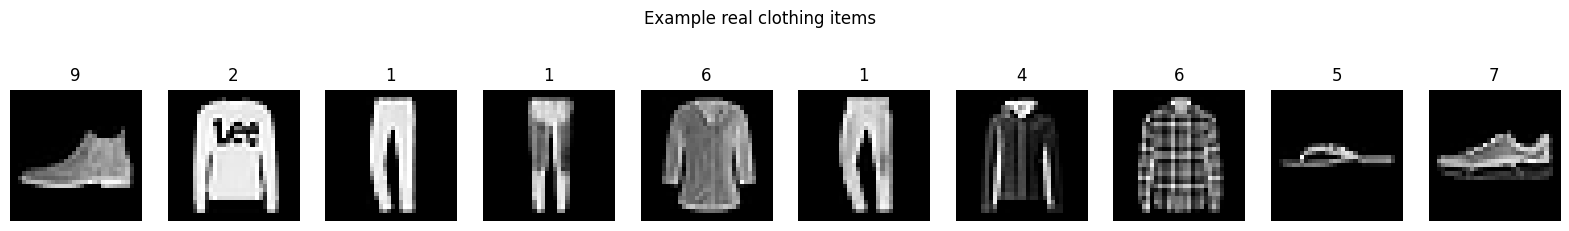

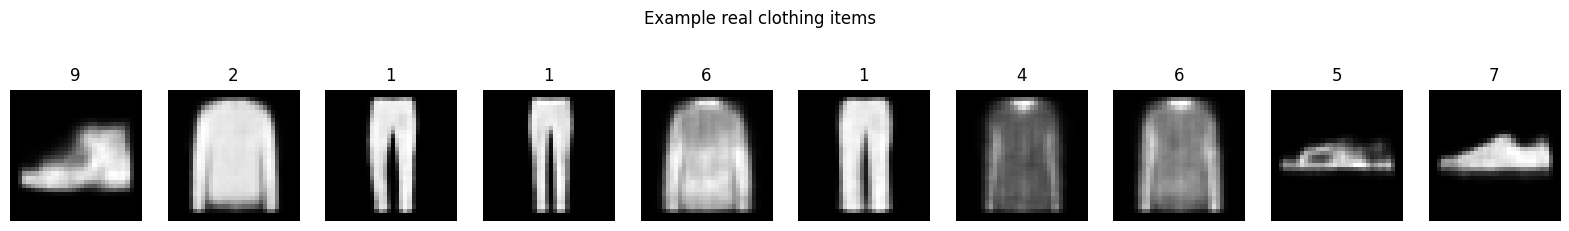

In [10]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)


plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(example_images[i], cmap="gray")
    plt.axis("off")
    plt.title(example_labels[i])
plt.suptitle("Example real clothing items")
plt.show()

plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructions[i], cmap="gray")
    plt.axis("off")
    plt.title(example_labels[i])
plt.suptitle("Example real clothing items")
plt.show()

## 6. Check Embeded value with the Encoder

157/157 [==============================] - 0s 1ms/step
[[-0.31162894 -1.2453159 ]
 [ 1.2992198   0.11240461]
 [ 0.712177    2.1737437 ]
 [-0.6968081   2.0626762 ]
 [ 0.44509178 -0.02247348]
 [ 0.8159314   1.7301329 ]
 [-1.068001    0.2991392 ]
 [-0.4315086   0.11741365]
 [-2.7131243  -1.117957  ]
 [-1.5590822  -1.6883609 ]]


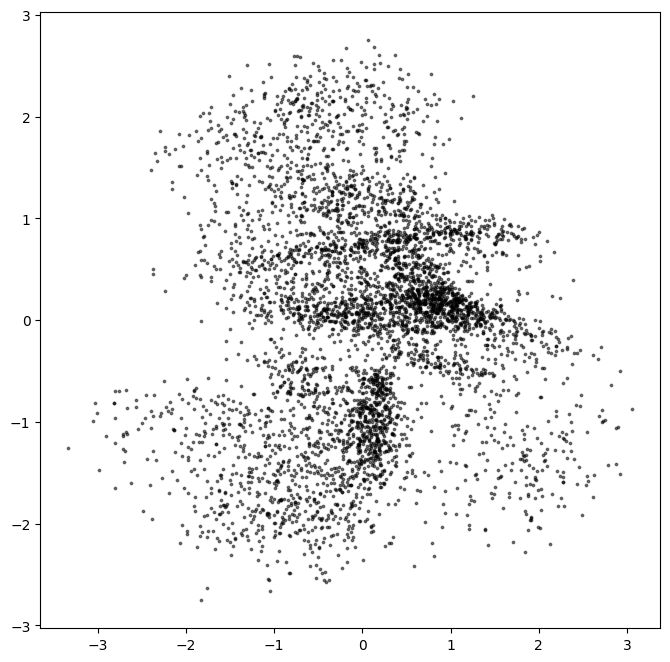

In [11]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

# Some examples of the embeddings
print(z[:10])

# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()



## 7. Generate using the decoder

1/1 [==============================] - 0s 12ms/step
[[-0.41029532 -0.27173738]
 [ 1.2542901   0.3267547 ]
 [ 2.04937349  0.65753997]
 [-0.90500907  0.1916049 ]
 [-2.05659052  0.18364873]
 [-1.38478572  0.35827653]
 [-0.87625217  0.94303147]
 [ 0.20076973 -0.47809876]
 [ 0.1170675  -0.0633831 ]
 [-0.1953674   3.35633544]
 [-0.51823707 -1.54487246]
 [ 0.4292944  -0.90506961]
 [ 0.60641607 -0.17297353]
 [ 0.76481243 -1.5653472 ]
 [-0.54240436  0.88922101]
 [ 0.5391435   0.1187566 ]
 [-1.60929975 -0.95488193]
 [-0.08224129 -1.52924777]]
[[0.34079466 0.39291198]
 [0.89513171 0.62807329]
 [0.9797872  0.74458311]
 [0.18273029 0.57597415]
 [0.01986282 0.57285549]
 [0.083059   0.63993181]
 [0.19044648 0.8271676 ]
 [0.57956068 0.31628996]
 [0.54659672 0.47473072]
 [0.42255267 0.99960509]
 [0.30214644 0.06118856]
 [0.6661455  0.18271425]
 [0.72788075 0.43133612]
 [0.77780838 0.05875076]
 [0.29376999 0.81305784]
 [0.70510608 0.5472659 ]
 [0.05377541 0.16981871]
 [0.46722742 0.06310152]]


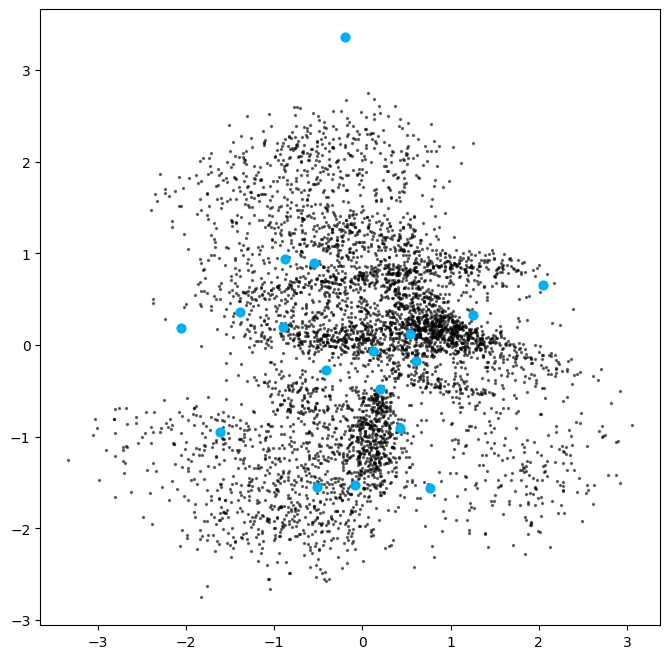

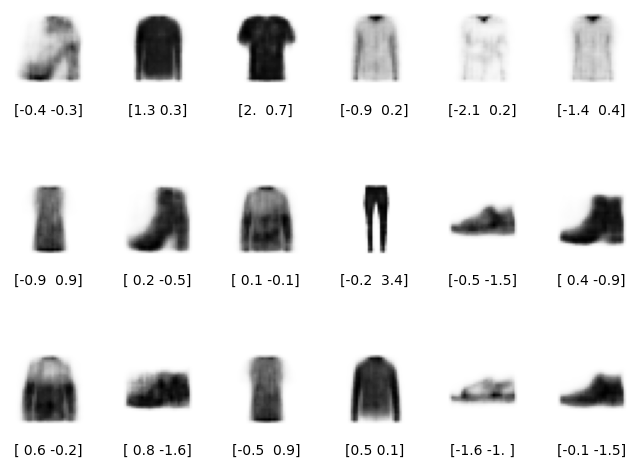

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)
# print(z_sample)
# print(p_sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


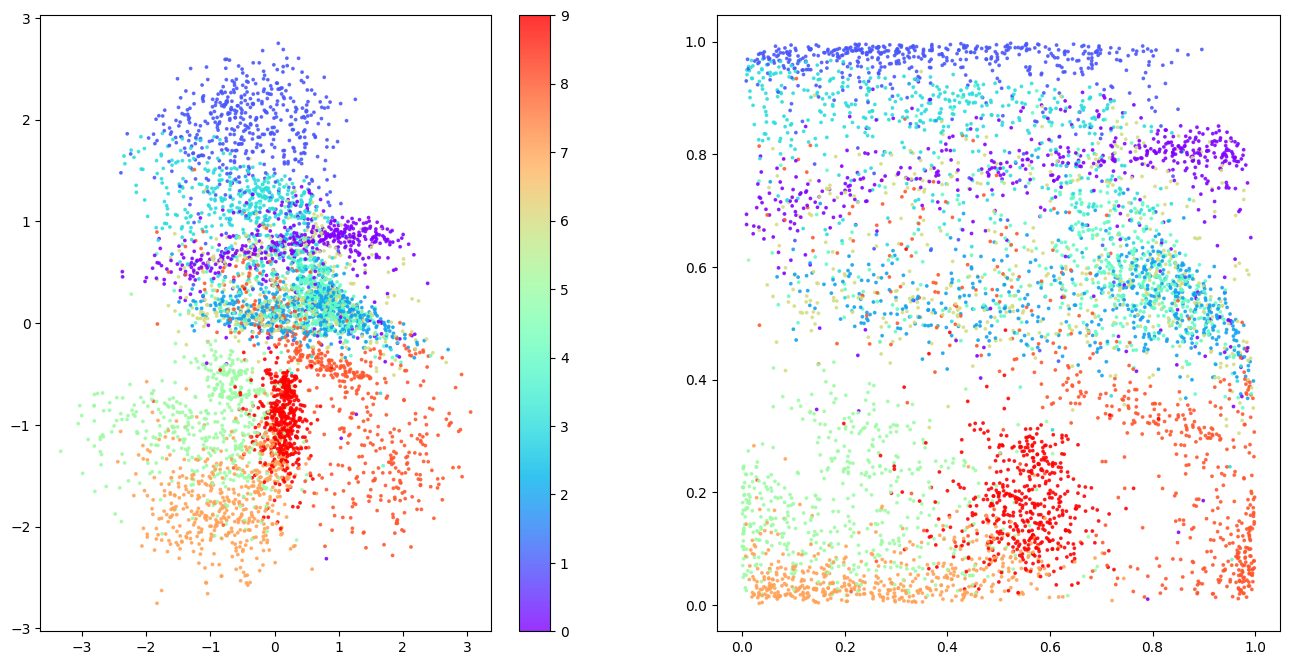

In [13]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 5ms/step


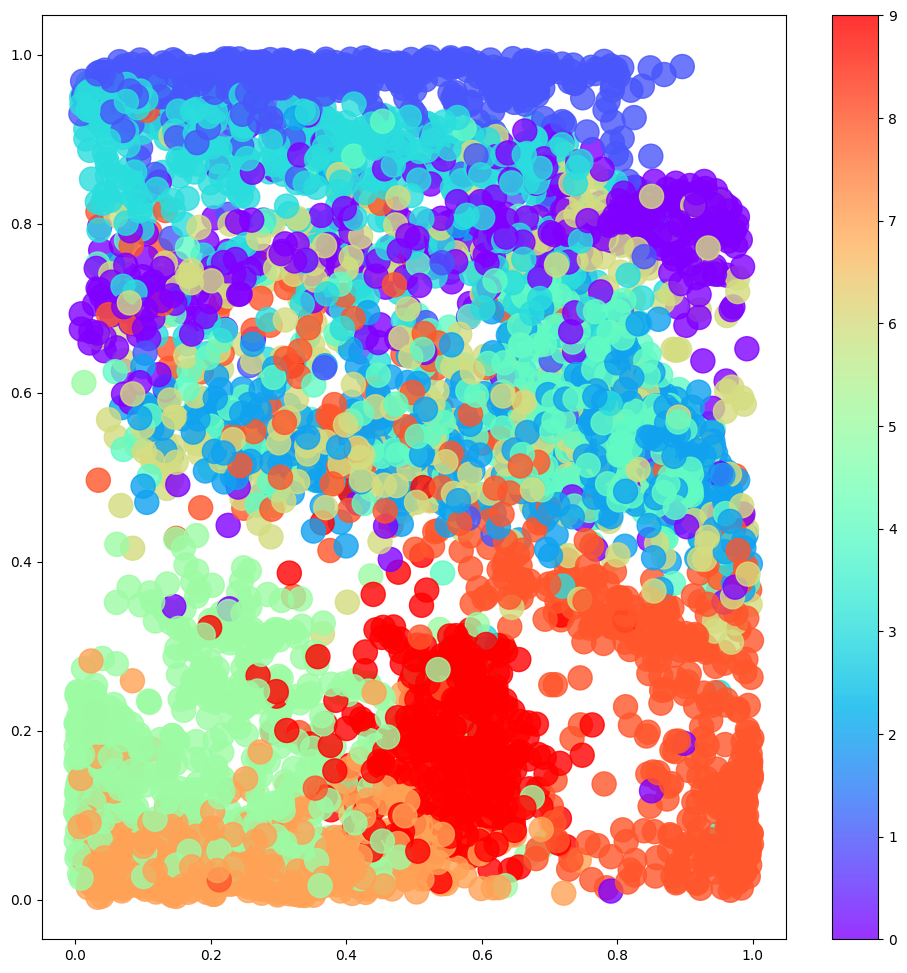

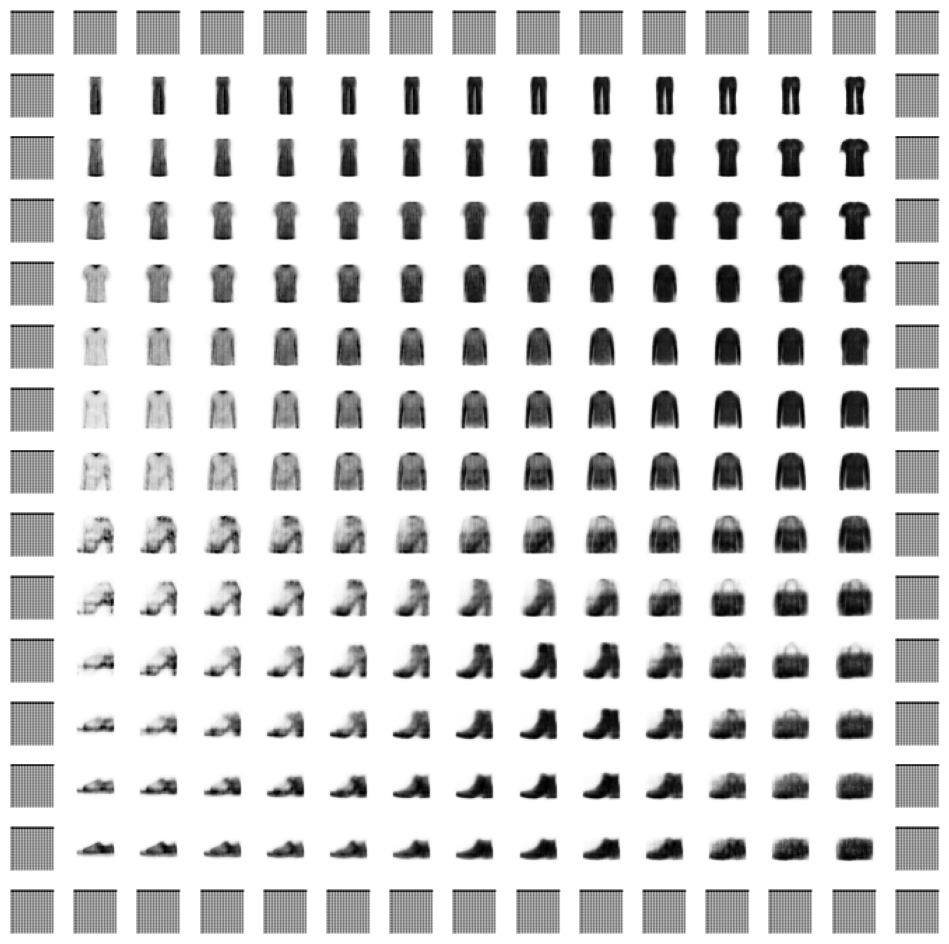

In [19]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")